# Wetterstationen Konstanz

__Abgedeckter Zeitraum:__
*09/04/24 bis 31/12/24*

__Stationen:__
*Bodanplatz*, *Marktstätte*, *Herose Park*, *Mainaustraße*, *Staad (Fähre)*, *Hörnle*,  
*Friedrichstrasse*, *Europapark*, *Stadtgarten*, *Riedstrasse*, *Döbele*, *Stephansplatz*

In [2]:
import pandas as pd
import numpy as np
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import csv
#import dash
#from dash import dcc, html
import plotly.graph_objects as go
import plotly.express as px
#import dash.dependencies as dd

In [3]:
ws = pd.read_csv("/Users/richie/Projects/SGC-K/data/data_weather_stations_2024.csv")
#ws.head()

In [4]:
#noch anpassen (zeitzone/sommerzeit mitbedenken), grade zu faul :)
ws['dateobserved'] = pd.to_datetime(ws['dateobserved'].str.split('[.+]', n=1).str[0])

#new variables: date, time, hour & week_of_year
ws['date'] = ws['dateobserved'].dt.date
ws['time'] = ws['dateobserved'].dt.time
ws['hour'] = ws['dateobserved'].dt.hour
#ws['week_of_year'] = ws['dateobserved'].dt.isocalendar().week

### Aggregation der Temperaturwerte: Berechnung Median pro Stunde&Wetterstation
- Intervalle zwischen den Messzeitpunkten sind sehr unterschiedlich, mal wenige minuten, mal stunden
- Ziel: ein Messergebnis pro Stunde pro Station -> falls mehrere Messungen: Median, falls kein Messergebnis vorhanden: nan

In [5]:
#calculate median values grouped by location, date & hour 
#drop irrelevant columns& round results to two decimal places
ws_hour = ws.drop(columns=['entity_id', 'dateobserved', 'time', 'entity_id']).groupby(['name', 'date', 'hour']).median().round(2).reset_index()
ws_hour.head()

,name,date,hour,atmosphericpressure,precipitation,relativehumidity,temperature,winddirection,windspeedavg,windspeedmax,windspeedmin,surfacetemperaturewintersense,temperaturewintersense
0,Bodanplatz,2024-04-10,22,983.4,0.89,52.30,19.4,287.0,0.00,0.10,0.0,NaN,NaN
1,Bodanplatz,2024-04-11,5,983.8,0.89,52.80,18.6,51.0,0.10,0.10,0.0,NaN,NaN
2,Bodanplatz,2024-04-11,8,985.0,0.97,47.30,10.7,299.0,0.10,0.10,0.0,NaN,NaN
3,Bodanplatz,2024-04-11,9,985.5,1.40,70.00,8.5,215.0,0.40,1.40,0.0,NaN,NaN
4,Bodanplatz,2024-04-11,10,985.9,1.46,66.74,9.1,204.0,0.85,1.95,0.1,NaN,NaN


In [6]:
#vollständigen dataframe erstellen, fehlende werte = nan
all_possible_combinations = pd.MultiIndex.from_product(
    [ws_hour['name'].unique(), pd.to_datetime(ws_hour['date']).unique(), range(24)],
    names=['name', 'date', 'hour'])

ws_compl = ws_hour.set_index(['name', 'date', 'hour']).reindex(all_possible_combinations, fill_value=np.nan)
ws_compl = ws_compl.reset_index()
ws_compl

,name,date,hour,atmosphericpressure,precipitation,relativehumidity,temperature,winddirection,windspeedavg,windspeedmax,windspeedmin,surfacetemperaturewintersense,temperaturewintersense
0,Bodanplatz,2024-04-10,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Bodanplatz,2024-04-10,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Bodanplatz,2024-04-10,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Bodanplatz,2024-04-10,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Bodanplatz,2024-04-10,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
76891,Stephansplatz,2024-12-24,19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
76892,Stephansplatz,2024-12-24,20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
76893,Stephansplatz,2024-12-24,21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
76894,Stephansplatz,2024-12-24,22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
#ws_day = ws.drop(columns=['entity_id', 'dateobserved', 'time', 'hour']).groupby(['name', 'date']).median().round(2).reset_index()
#ws_week = ws.drop(columns=['entity_id', 'dateobserved', 'time', 'date', 'hour']).groupby(['name', 'week_of_year']).median().round(2).reset_index()

### Unplausible & fehlende Messwerte?
- Um unplausible Messwerte auszuschließen: grobe Outlieranalyse -> Z-scores für gruppierte Daten (Datum & Stunde) berechnen

In [8]:
#unplausible werte finden
def outlier(ws_compl, threshold):  
    def z_score(group):
        #z score berechnen -> nur temperaturwerte miteinbezogen
        mean_temp = group['temperature'].mean() #für jede "gruppe" aus standorten an einem datum und einer stunde
        std_temp = group['temperature'].std() 
        z_scores = (group['temperature'] - mean_temp) / std_temp
        return z_scores

    #daten gruppieren (nach datum und stunde)
    ws_compl.loc[:, 'z_score'] = ws_compl.groupby(['date', 'hour']).apply(z_score).reset_index(level=[0, 1], drop=True)
    
    #z score über schwellenwert (pos/neg)? -> outlier
    outlier = ws_compl['z_score'].abs() > threshold
    outlier = ws_compl[outlier]
    return outlier

ws_compl_outl = outlier(ws_compl, threshold=3) #= 3 standardabweichungen
ws_compl_outl = ws_compl_outl.sort_values(by='z_score', ascending=False)
ws_compl_outl

/var/folders/k5/njyjkt_x2mg0jkrvd3g_wnhc0000gn/T/ipykernel_7826/725812355.py:11: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  ws_compl.loc[:, 'z_score'] = ws_compl.groupby(['date', 'hour']).apply(z_score).reset_index(level=[0, 1], drop=True)


,name,date,hour,atmosphericpressure,precipitation,relativehumidity,temperature,winddirection,windspeedavg,windspeedmax,windspeedmin,surfacetemperaturewintersense,temperaturewintersense,z_score
29,Bodanplatz,2024-04-11,5,983.8,0.89,52.8,18.6,51.0,0.1,0.1,0.0,NaN,NaN,3.131190
22,Bodanplatz,2024-04-10,22,983.4,0.89,52.3,19.4,287.0,0.0,0.1,0.0,NaN,NaN,3.094371


In [9]:
#plt.figure(figsize=(6,4))
#plt.hist(ws_compl['z_score'], bins=100, color='skyblue', edgecolor='black')
#plt.title('distribution z scores')
#plt.xlabel('z-score')
#plt.ylabel('anzahl werte')

In [10]:
#checken
#19.4 grad bodanplatz um 22.00 im april?
ws_compl[(ws_compl['date'].astype(str) == '2024-04-10') & (ws_compl['hour'] ==22)]

,name,date,hour,atmosphericpressure,precipitation,relativehumidity,temperature,winddirection,windspeedavg,windspeedmax,windspeedmin,surfacetemperaturewintersense,temperaturewintersense,z_score
22,Bodanplatz,2024-04-10,22,983.40,0.89,52.30,19.40,287.0,0.00,0.10,0.00,NaN,NaN,3.094371
6430,Döbele,2024-04-10,22,983.35,22.67,79.09,7.10,217.5,0.10,0.40,0.00,NaN,NaN,-0.454418
12838,Europapark,2024-04-10,22,983.20,51.31,80.30,6.90,242.5,0.35,0.40,0.10,8.58,5.23,-0.512122
19246,Friedrichstrasse,2024-04-10,22,981.40,13.77,76.20,7.60,58.0,0.20,0.40,0.10,NaN,NaN,-0.310158
25654,Fähre Staad,2024-04-10,22,983.35,21.02,71.94,8.05,316.5,0.55,0.85,0.20,NaN,NaN,-0.180325
32062,Herose-Park,2024-04-10,22,983.50,12.65,74.39,8.00,281.0,0.30,0.70,0.10,NaN,NaN,-0.194751
38470,Hörnle,2024-04-10,22,982.90,0.00,74.50,7.30,277.0,0.35,0.60,0.05,NaN,NaN,-0.396714
44878,Mainaustrasse,2024-04-10,22,982.45,17.61,78.24,7.50,158.0,0.25,0.60,0.00,NaN,NaN,-0.339010
51286,Marktstätte,2024-04-10,22,983.75,41.97,72.44,8.85,48.5,0.25,0.65,0.05,9.22,8.01,0.050491
57694,Riedstrasse,2024-04-10,22,983.20,0.45,83.65,6.25,59.0,0.20,0.30,0.10,NaN,NaN,-0.699660


In [11]:
#18 grad bodanplatz um 5uhr morgens im april? 
ws_compl[(ws_compl['date'].astype(str) == '2024-04-11') & (ws_compl['hour'] == 5)]

#scheint jemand (zur wartung?) dran rumgewerkelt zu haben, werte verzerrt um 22.00 und 05.00
#zwischen 22 und 5 uhr keine messungen 

,name,date,hour,atmosphericpressure,precipitation,relativehumidity,temperature,winddirection,windspeedavg,windspeedmax,windspeedmin,surfacetemperaturewintersense,temperaturewintersense,z_score
29,Bodanplatz,2024-04-11,5,983.80,0.89,52.80,18.60,51.0,0.10,0.10,0.00,NaN,NaN,3.131190
6437,Döbele,2024-04-11,5,983.70,22.67,95.00,3.20,210.0,0.10,0.20,0.00,NaN,NaN,-0.468461
12845,Europapark,2024-04-11,5,983.45,51.31,98.44,3.20,220.0,0.55,0.85,0.35,3.70,2.31,-0.468461
19253,Friedrichstrasse,2024-04-11,5,981.70,13.77,93.44,3.80,50.0,0.20,0.35,0.00,NaN,NaN,-0.328215
25661,Fähre Staad,2024-04-11,5,983.55,21.02,89.74,4.65,284.5,0.50,1.00,0.25,NaN,NaN,-0.129533
32069,Herose-Park,2024-04-11,5,983.90,12.65,96.64,4.20,315.5,0.25,0.45,0.15,NaN,NaN,-0.234717
38477,Hörnle,2024-04-11,5,983.15,0.00,96.40,4.30,267.5,0.55,0.75,0.25,NaN,NaN,-0.211343
44885,Mainaustrasse,2024-04-11,5,982.75,17.61,95.60,4.05,57.5,0.30,0.60,0.05,NaN,NaN,-0.269779
51293,Marktstätte,2024-04-11,5,984.10,41.97,87.00,4.95,221.0,0.60,0.95,0.15,5.29,4.22,-0.059410
57701,Riedstrasse,2024-04-11,5,983.50,0.45,97.00,2.50,110.0,0.40,0.70,0.20,NaN,NaN,-0.632081


In [12]:
#insg. nur zwei sehr auffällige werte (sehr sicher falsche messergebnisse) -> durch nan ersetzen
ws_compl.loc[~((ws_compl['z_score'].abs() <= 3) | ws_compl['z_score'].isna()), 'temperature'] = np.nan

### Fehlende Messwerte

In [15]:
#wieviele missing hours pro tag und location?
missing_hours_per_location_day = ws_compl[ws_compl['temperature'].isna()].groupby(['name', 'date']).size().reset_index(name='missing_hours')
missing_hours_per_location_day

,name,date,missing_hours
0,Bodanplatz,2024-04-09,24
1,Bodanplatz,2024-04-10,24
2,Bodanplatz,2024-04-11,8
3,Bodanplatz,2024-04-26,1
4,Bodanplatz,2024-05-29,1
...,...,...,...
430,Stephansplatz,2024-12-27,24
431,Stephansplatz,2024-12-28,24
432,Stephansplatz,2024-12-29,24
433,Stephansplatz,2024-12-30,24


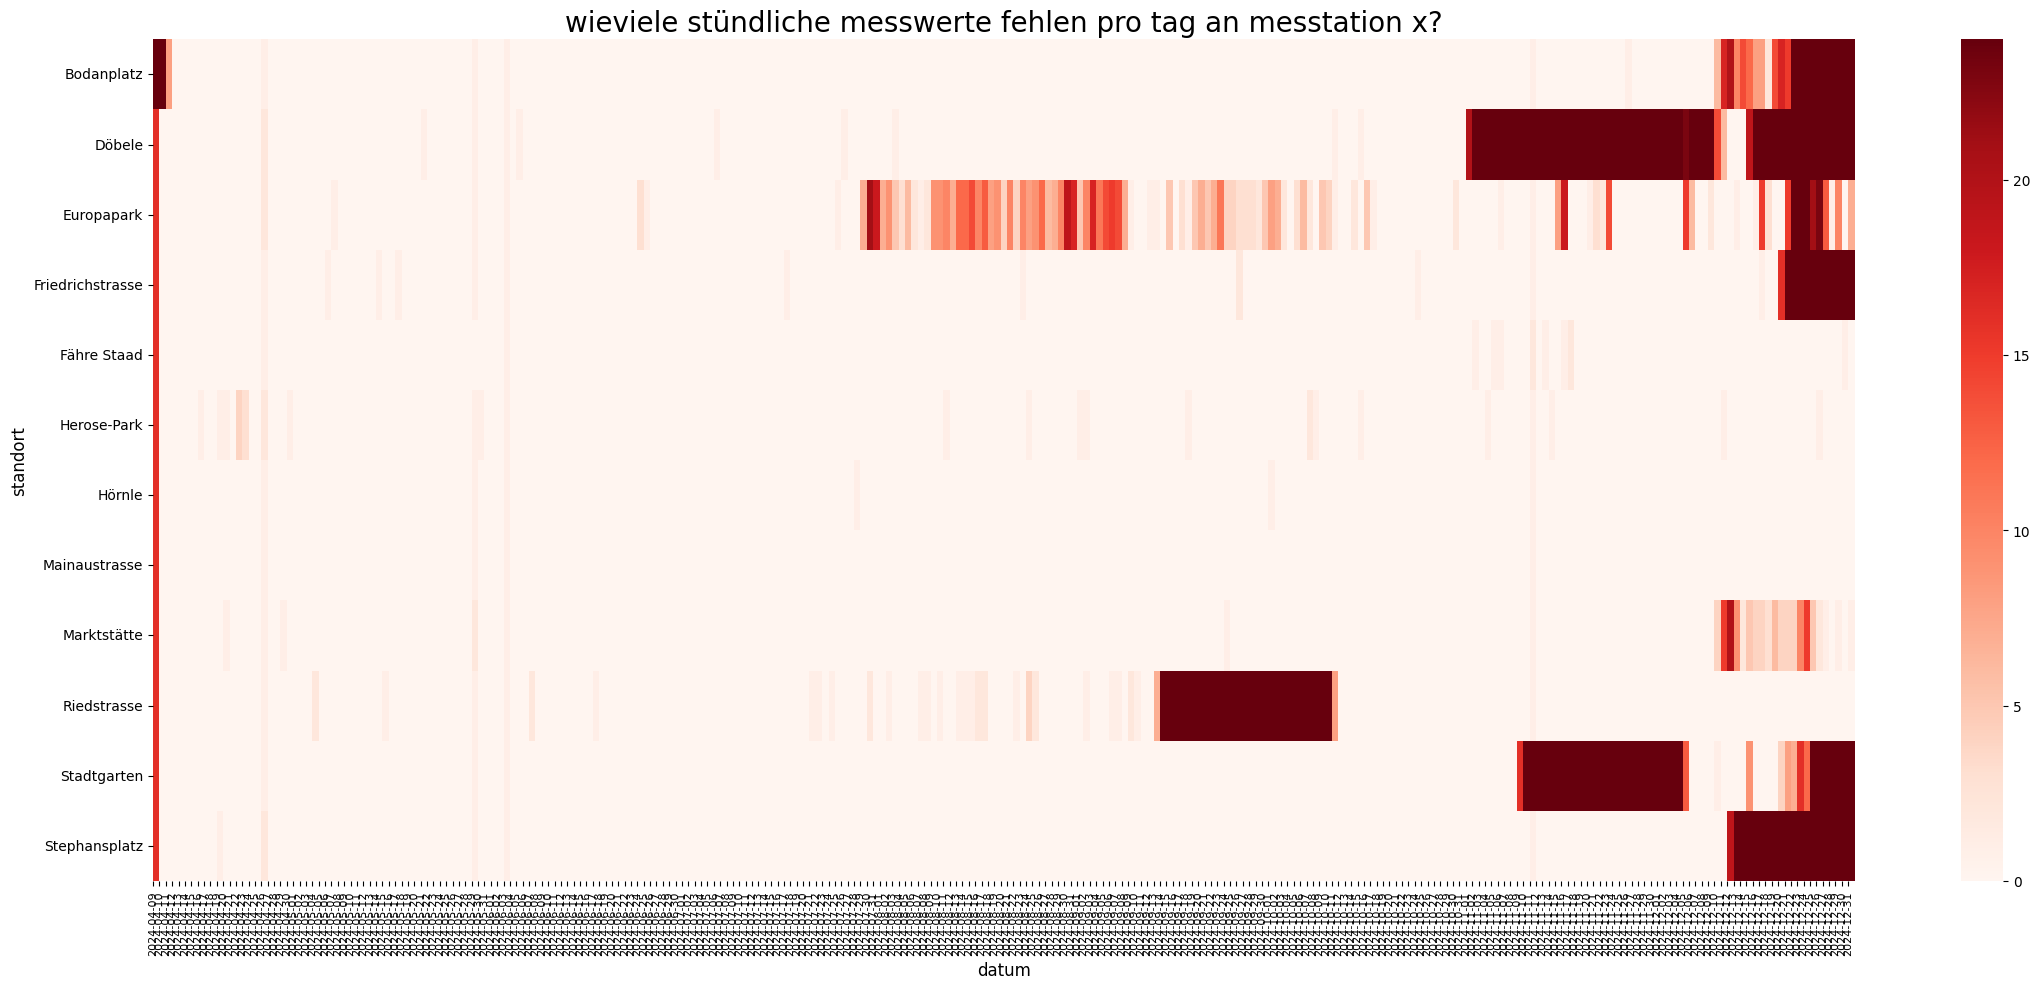

In [16]:
#plot für mehr überblick :)
#merge with complete dataframe, missing hours = 0 if day is complete
all_combinations = ws_compl.reset_index()[['name', 'date']].drop_duplicates()
missing_hours_per_location_day = all_combinations.merge(missing_hours_per_location_day, on=['name', 'date'], how='left')
missing_hours_per_location_day['missing_hours'] = missing_hours_per_location_day['missing_hours'].fillna(0)

#pivot
data = missing_hours_per_location_day.pivot_table(index='name', columns='date', values='missing_hours')

#plotten
plt.figure(figsize=(23, 10))
sns.heatmap(data, cmap='Reds', vmax=24, cbar=True)
plt.title('wieviele stündliche messwerte fehlen pro tag an messtation x?', fontsize=20)
plt.xlabel('datum', fontsize=12)
plt.ylabel('standort', fontsize=12)
plt.xticks(ticks=range(len(data.columns)), labels=data.columns.strftime('%Y-%m-%d'), rotation=90, fontsize=8)
plt.tight_layout()
plt.savefig("missing_values.png")


In [ ]:
#spannend vorallem sommermonate -> fehlende stunden mai-sept prim im europapark & in der riedstraße

#riedstraße fällt ab mitte september aus
#einzige station im industriegebiet -> zu spannend um station auszuklammern

#europapark immer wieder mit größeren fehlenden blocks 
#nicht ganz so spannend, auch andere grünflächen mit messstationen dabei -> raus

#restliche fehlende werte -> interpolation

In [20]:
#europapark raus
ws_compl_summer = ws_compl[ws_compl['name'] != 'Europapark']

In [21]:
#wieviel interpolation nötig?
def zeitraum(ws_compl_summer, vorhandene_stunden, anzahl_stationen=11):
    
    #nas droppen
    ws_compl_ohne_na = ws_compl.dropna(subset=['temperature'])

    #eindeutige stunden pro standort und datum zählen
    #filtern nach stunden-kriterium, eig 24
    ws_compl_ohne_na = ws_compl_ohne_na.groupby(['name', 'date'])['hour'].nunique()
    ws_compl_ohne_na = ws_compl_ohne_na[ws_compl_ohne_na >= vorhandene_stunden].reset_index()

    #filtern nach tagen, an denen alle relevanten stationen das stunden-kriterium erfüllen
    complete_days = ws_compl_ohne_na.groupby('date')['name'].nunique()
    complete_days = complete_days[complete_days >= anzahl_stationen].reset_index()

    #differenz zwischen tagen berechnen
    complete_days = complete_days.sort_values(by='date')
    complete_days['day_diff'] = complete_days['date'].diff().dt.days

    #zeiträume mit lücke (größer als 1tag)?
    periods = []
    period_start = complete_days['date'].iloc[0]
    count = 1

    for i in range(1, len(complete_days)): 
        if complete_days['day_diff'].iloc[i] > 1:  #abstand >1tag
            if count >= 7:  # mindestens 1 woche
                periods.append((period_start, complete_days['date'].iloc[i-1], count))
            period_start = complete_days['date'].iloc[i]  
            count = 1
        else:
            count += 1

    periods = pd.DataFrame(periods, columns=['start date', 'end date', 'duration'])
    return periods

In [22]:
#ohne interpolation/vollständig
zeitraum(ws_compl_summer, vorhandene_stunden=24)

,start date,end date,duration
0,2024-04-10,2024-04-18,9
1,2024-04-27,2024-05-28,32
2,2024-06-04,2024-07-29,56
3,2024-10-16,2024-11-01,17


In [23]:
#max eine stunde am tag pro station
zeitraum(ws_compl_summer, vorhandene_stunden=23)

,start date,end date,duration
0,2024-04-10,2024-04-25,16
1,2024-04-27,2024-07-29,94
2,2024-07-31,2024-08-15,16
3,2024-08-26,2024-09-14,20
4,2024-10-11,2024-11-08,29


In [24]:
#max zwei stunden am tag pro station
zeitraum(ws_compl_summer, vorhandene_stunden=22) 

,start date,end date,duration
0,2024-04-10,2024-08-23,136
1,2024-08-25,2024-09-14,21
2,2024-10-11,2024-11-08,29


In [25]:
#zeitraum 0 + 1 -> 5 monate im sommer , ab 14/09 fällt riedstraße aus -> dafür 24-08-24 genauer anschauen
ws_compl_summer[(ws_compl_summer['date'] == '2024-08-24') & (ws_compl_summer['temperature'].isna())]

,name,date,hour,atmosphericpressure,precipitation,relativehumidity,temperature,winddirection,windspeedavg,windspeedmax,windspeedmin,surfacetemperaturewintersense,temperaturewintersense,z_score
35324,Herose-Park,2024-08-24,20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
60944,Riedstrasse,2024-08-24,8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
60945,Riedstrasse,2024-08-24,9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
60946,Riedstrasse,2024-08-24,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
60952,Riedstrasse,2024-08-24,16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [26]:
#riedstraße 3h (8-10.00) plus 16.00 -> kein größerer ausfall

In [27]:
#zeitraum: 2024-04-10 bis 2024-09-14
ws_compl_summer = ws_compl_summer[(ws_compl_summer['date'] > '2024-04-10')&(ws_compl_summer['date'] < '2024-09-14')]
ws_compl_summer.to_csv('ws_compl_summer.csv')

# WS_COMPL_SUMMER EINMAL als CSV speichern und von nun an verwenden: 
## das ist unser abgeklopfter, langer Zeitraum (10.April - 14.September, 24) mit unserem gewählten Mindestmaß an Messungen. Die noch existierenden Lücken müssen nun noch interpoliert werden. 

In [ ]:
#interpolate
def linear_interpolation(df, column):
    #station für station durchgehen
    for station, group in df.groupby('name'):
        #fehlende Werte nur in der gruppe (station) auffüllen -> linear
        df.loc[group.index, column] = group[column].interpolate(method='linear', limit_direction='both')

    return df

ws_compl_summer_li = linear_interpolation(ws_compl_summer, 'temperature')
ws_compl_summer_li = ws_compl_summer_li[['name', 'date', 'hour', 'temperature']]

In [ ]:
#final
ws_compl_summer_li


### Welche Muster gibt es in der Temperaturentwicklung der Stadtteile?

In [ ]:
ws_compl_summer_li['datetime'] = pd.to_datetime(ws_compl_summer_li['date']) + pd.to_timedelta(ws_compl_summer_li['hour'], unit='h')

#lineplot über kompletten zeitraum zum zoomen
fig = px.line(ws_compl_summer_li, x='datetime', y='temperature', color='name', 
              labels={'datetime': 'datum & stunde'},
              title='messwerte der wetterstationen: 2024-04-10 bis 2024-09-14')

fig.update_layout(
    xaxis_title='datum & stunde',
    yaxis_title='temperatur',
    template='plotly_dark')

In [ ]:
#zoom: woche um den heißesten tag im juli
ws_compl_summer_li_jul = ws_compl_summer_li[(ws_compl_summer_li['date']>='2024-07-29') &(ws_compl_summer_li['date']<='2024-08-04')]

fig = px.line(ws_compl_summer_li_jul, x='datetime', y='temperature', color='name', 
              labels={'datetime': 'datum & stunde'},
              title='messwerte der wetterstationen 07/29-08/04')

fig.update_layout(
    xaxis_title='datum & stunde',
    yaxis_title='temperatur',
    template='plotly_dark')

In [ ]:
#zoom heißester tag: 31/07
ws_compl_summer_li_jul_31 = ws_compl_summer_li[ws_compl_summer_li['date']=='2024-07-31']

fig = px.line(ws_compl_summer_li_jul_31, x='datetime', y='temperature', color='name', 
              labels={'datetime': 'datum & stunde'},
              title='messwerte der wetterstationen 07/31')

fig.update_layout(
    xaxis_title='datum & stunde',
    yaxis_title='temperatur',
    template='plotly_dark')

In [ ]:
#auf die stunde gemittelt -> wie warm ist es durchschnittlich in stunde x an station y & über alle stationen hinweg?
#zeitraum 2024-04-10 bis 2024-09-14
mean_temperatures = ws_compl_summer_li.groupby(['hour', 'name'])['temperature'].mean().reset_index()
global_mean = ws_compl_summer_li.groupby(['hour'])['temperature'].mean().reset_index()

plt.figure(figsize=(14, 8))
sns.lineplot(data=mean_temperatures, x='hour', y='temperature',  hue='name',marker='o', palette='Set2')
sns.lineplot(data=global_mean, x='hour', y='temperature', color='black', linewidth=2)
plt.title('wie warm war es durchschnittlich in stunde x zw. 2024-04-10 bis 2024-09-14?')
plt.xlabel('stunde')
plt.ylabel('durchschnittstemperatur')
plt.xticks(range(24))  
plt.tight_layout()

In [ ]:
#auf die stunde gemittelt -> wie warm ist es durchschnittlich in stunde x an station y?
#zeitraum 2024-04-10 bis 2024-09-14
mean_temperatures = ws_compl_summer_li.groupby(['hour', 'name'])['temperature'].mean().reset_index()
heatmap = mean_temperatures.pivot_table(index='name', columns='hour', values='temperature')

plt.figure(figsize=(14, 8))
sns.heatmap(heatmap, cmap='Reds', annot=True, fmt='.2f', cbar_kws={'label': 'durchschnittstemperatur'})
plt.title('stündliche stations-mittelwerte 2024-04-10 bis 2024-09-14')
plt.xlabel('stunde')
plt.ylabel('stationen')
plt.tight_layout()

In [ ]:
#splitten nach monaten -> wie warm ist es durchschnittlich in stunde x an station y?
months = ['2024-05', '2024-06', '2024-07', '2024-08'] #vollständige monate
all_months_data = ws_compl_summer_li[ws_compl_summer_li['date'].dt.strftime('%Y-%m').isin(months)]

#max/min manuell festlegen/für alle plots identisch
max_temp = 27
min_temp = 10

for i in range(0, len(months), 2):
    #zwei subplots nebeneinander
    fig, axes = plt.subplots(1, 2, figsize=(14, 8))

    for j, month in enumerate(months[i:i+2]):
        #filtern für aktuellen monat
        monthly_data = ws_compl_summer_li[ws_compl_summer_li['date'].dt.strftime('%Y-%m') == month]
        
        #berechnung mittelwerte
        mean_temperatures = monthly_data.groupby(['hour', 'name'])['temperature'].mean().reset_index()
        
        #heatmap
        heatmap = mean_temperatures.pivot_table(index='name', columns='hour', values='temperature')
        sns.heatmap(heatmap, cmap='Reds', annot=False, fmt='.2f', 
                    cbar_kws={'label': 'durchschnittstemperatur'},
                    ax=axes[j], vmin=min_temp, vmax=max_temp)
        axes[j].set_title(f'stündliche stations-mittelwerte {month}')
        axes[j].set_xlabel('stunde')
        axes[j].set_ylabel('')

    plt.tight_layout()

In [ ]:
#fokus abweichung
#gemessen am durchschnitt - wie viel wärmer/kälter ist es durchschnittlich in stunde x an station y?
#durchschnitt aller stationen in stunde x, zeitraum 2024-04-10 bis 2024-09-14
mean_temperatures = ws_compl_summer_li.groupby(['hour', 'name'])['temperature'].mean().reset_index()
global_mean = ws_compl_summer_li.groupby(['hour'])['temperature'].mean().reset_index()
global_mean = global_mean.rename(columns={'temperature': 'mean_temperature'})
heatmap = pd.merge(mean_temperatures, global_mean, on='hour')
heatmap['temperature_deviation'] = heatmap['temperature'] - heatmap['mean_temperature']

heatmap = heatmap.pivot_table(index='name', columns='hour', values='temperature_deviation')
plt.figure(figsize=(14, 8))
sns.heatmap(heatmap, cmap='coolwarm', annot=True, fmt='.2f', cbar_kws={'label': 'temperaturabweichung'})
plt.title('abweichung des stündlichen stations-mittelwert vom gesamten mittelwert pro stunde 2024-04-10 bis 2024-09-14')
plt.xlabel('stunde')
plt.ylabel('stationen')
plt.tight_layout()

In [ ]:
#splitten nach monaten -> wie viel wärmer/kälter ist es durchschnittlich in stunde x an station y im vgl zum durchschnitt?
months = ['2024-05', '2024-06', '2024-07', '2024-08']
max_temp = 1.5 #manuell
min_temp = -1.5

for i in range(0, len(months), 2):
    #zwei subplots nebeneinander
    fig, axes = plt.subplots(1, 2, figsize=(14, 8))

    for j, month in enumerate(months[i:i+2]):
        #filtern für aktuellen monat
        monthly_data = ws_compl_summer_li[ws_compl_summer_li['date'].dt.strftime('%Y-%m') == month]
        
        #berechnung mittelwerte
        mean_temperatures = monthly_data.groupby(['hour', 'name'])['temperature'].mean().reset_index()
        global_mean = monthly_data.groupby(['hour'])['temperature'].mean().reset_index()
        global_mean = global_mean.rename(columns={'temperature': 'mean_temperature'})

        #berechnung temperaturabweichung
        heatmap = pd.merge(mean_temperatures, global_mean, on='hour')
        heatmap['temperature_deviation'] = heatmap['temperature'] - heatmap['mean_temperature']
        
        #heatmap
        heatmap = heatmap.pivot_table(index='name', columns='hour', values='temperature_deviation')
        sns.heatmap(heatmap, cmap='coolwarm', annot=False, fmt='.2f', 
                    cbar_kws={'label': 'temperaturabweichung'}, ax=axes[j], vmin=min_temp, vmax=max_temp)
        axes[j].set_title(f'abweichung stündlicher stations-mittelwert vom gesamten mittelwert {month}')
        axes[j].set_xlabel('stunde')
        axes[j].set_ylabel('')

    plt.tight_layout()


### Kartendarstellung

In [ ]:
#add longitude/lattitude
data_dict = {
    'Bodanplatz': {'lat': 47.657899012304824, 'lon': 9.17444396766142},
    'Döbele': {'lat': 47.65825820974091, 'lon': 9.16914645368634},
    'Europapark': {'lat': 47.66808600077786, 'lon': 9.163557559052885},
    'Friedrichstrasse': {'lat': 47.678458072950214, 'lon': 9.186019286223265},
    'Fähre Staad': {'lat': 47.68217119014172, 'lon': 9.211396249781625},
    'Herose-Park': {'lat': 47.66979851881541, 'lon': 9.174446994165617},
    'Hörnle': {'lat': 47.666848849776954, 'lon': 9.214460185458156},
    'Mainaustrasse': {'lat': 47.68586480074947, 'lon': 9.194751953688005},
    'Marktstätte': {'lat': 47.660442915344255, 'lon': 9.176488194165042},
    'Riedstrasse': {'lat': 47.684223121201974, 'lon': 9.14735511016288},
    'Stadtgarten': {'lat': 47.66232704575617, 'lon': 9.17908782234721},
    'Stephansplatz': {'lat': 47.6624407842675, 'lon': 9.174113100340438}}

with open('orte_koordinaten.csv', mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['name', 'lat', 'lon']) 
    for place, coordinates in data_dict.items():
        writer.writerow([place, coordinates['lat'], coordinates['lon']])
        
standorte = pd.read_csv('orte_koordinaten.csv')
standorte

......